# Time Series Analysis of the company Go Bird GmbH

The main purpose here it's use some time series analysis based in some visualizations and techniques to extract knowledge of the evolution in the price of the stocks of a fictional company called GoBird GmbH. 

The whole idea it's have an undestanding in how this stock is and some particularities of their behaviour bases in the close price of the day. 

With this in mind we can do the right questions and at the end we'll train an ARIMA model to see if we can predict the future of this stock in a one-step in the future way.

The main point when we perform some analysis of time seris it is to answer the question: _this data it is time dependent?_. If yes, we should go to use this kind of analysis. 

But first at all, lets import some basic packages that we'll use and load or database.

## Imports and Data Load

In [18]:
# Standard Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for Time Series Analysis
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.metrics import mean_squared_error

%pylab inline
pylab.rcParams['figure.figsize'] = (14, 9)

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Data Import
df = pd.read_csv('go-bird-stocks.csv')

Populating the interactive namespace from numpy and matplotlib


Let's check our data taking a quick look in our dataframe. 

In [19]:
# First look in the data
df.head(3)

,month,close
0,2019-01,29.67
1,2019-02,31.26
2,2019-03,34.96


As we can see it is a univariate time series database with an float in the value. Now we'll build a `dateRange` object to attach in our time series to make the plot nicer with the right dates. Our stocks are distributed in the first day of the IPO `1/1/2019` to `12/31/2030` in a monhtly basis.

In [20]:
# We'll use a date range to pass the date for the graphs
dateRange = pd.date_range('1/1/2019', '12/31/2030', freq='M')

With our `dateRange` established we'll create out `time series object`. We'll use this object for all analysis that we need to do. For that we'll use the mean agregated by `month` in a spare way just to create the right object to pass to the estimators.

## Pre-Processing

In [21]:
ts = df.groupby(["month"])["close"].agg('mean')

Now we'll do some exploratory data analysis over our `time series` object to try to find some knowledge in the data.

## Exploratory Data Analysis

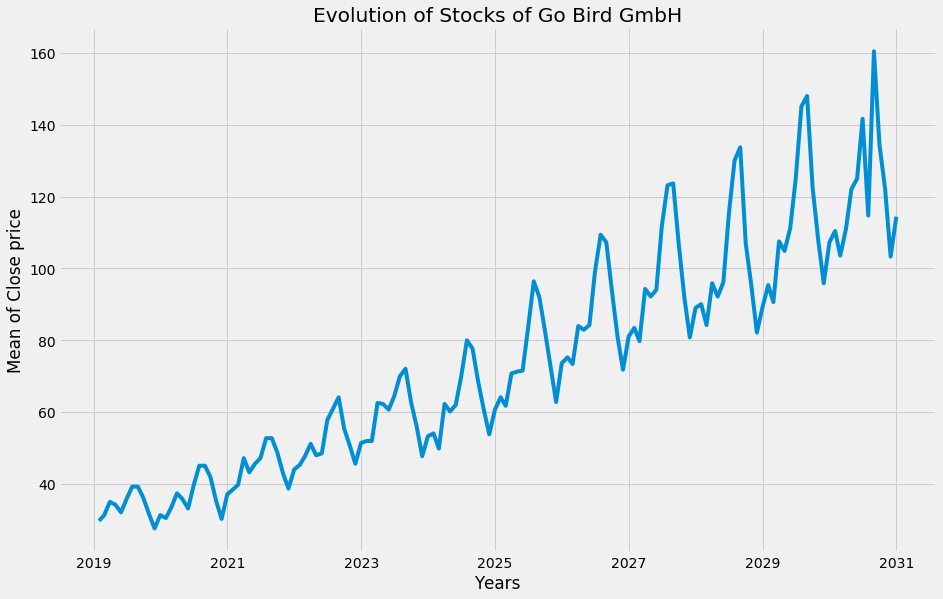

In [22]:
# Evolution of Stocks of Go Bird GmbH
ts.astype('float')
plt.figure(figsize=(14,9))
plt.title('Evolution of Stocks of Go Bird GmbH')
plt.xlabel('Years')
plt.ylabel('Mean of Close price')
plt.plot(dateRange, ts);

Wow, nice chart. This indicates that our stock had a good evolution during the years with a steadly growth thru the years. But we had some valleys and peaks during this growth. 


Every time series had these 4 components:

* **Level**: Mean and variance of the values over the time
* **Trend**: Upwards or downwards in the values over the time 
* **Seasonality**: Repeatable cycles along the time with the same intensity
* **Noise**: Unknown variations not captured by the time series(_i.e._ exogenous factors)

If we have the variance and mean ocurring along the time we can assume that we have **stationary** in our time series.

But before jump in this terms, let's discuss about Moving Averages... 

Moving Average it's a tool useds to smoothing out a time series creating an average for every date in the time series with some time of lag. Using Moving Averages we can remove the "noisy" moviments that can occur in the short term. 

But let's see in a practical way. In this following graph we'll use 12 months behind to see the trend in our Moving Average. 

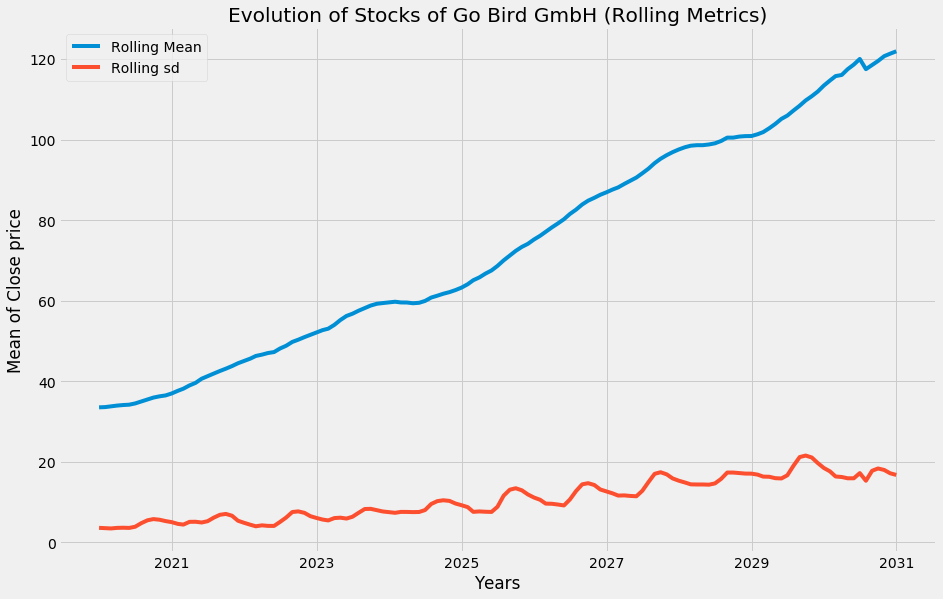

In [23]:
plt.figure(figsize=(14,9))
plt.plot(dateRange, ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(dateRange, ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.title('Evolution of Stocks of Go Bird GmbH (Rolling Metrics)')
plt.xlabel('Years')
plt.ylabel('Mean of Close price')
plt.legend();

Looking this Graph we can see that using a moving average of 12 months we can see the growth trend in place. Other thing that we can see too it's the standard deviation it's growing too. It means that we have a solid and steady growth but the uncertanties are growing too, but in a minor level. 

One good topic about Time Series analysis it's the decomposition of the time series. As we discussed before we might have the Trend, the Seasonality and the noise in our time series. To check if this occurs let's decompose our time series.

Populating the interactive namespace from numpy and matplotlib


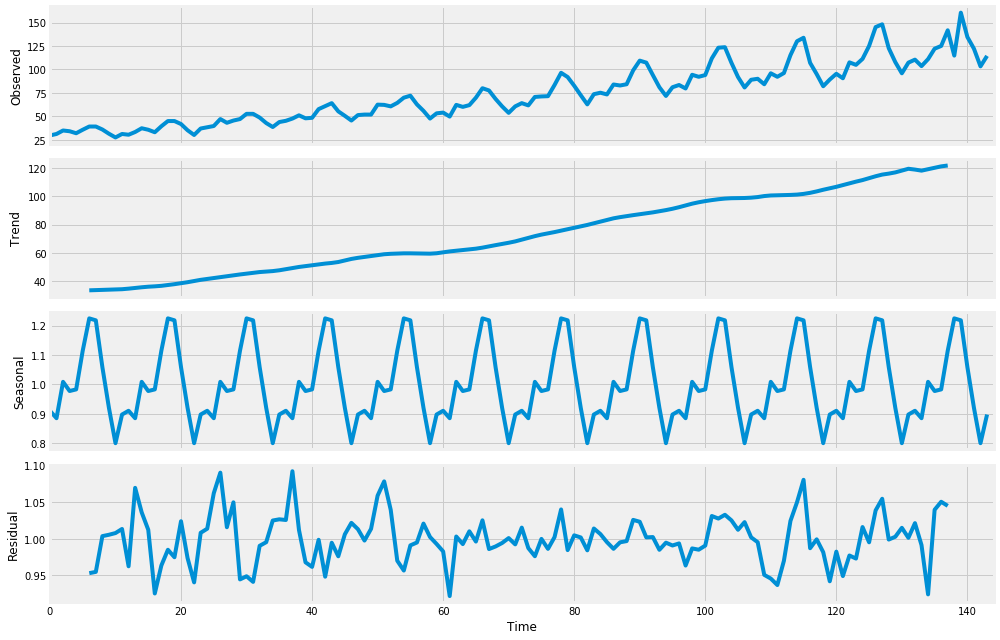

In [24]:
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 9)

import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()

In the first graph we have the _**Observed**_ that means of time series it self without any transformation. 

The second graph it is our _**Trend**_. As we can see, we have a solid trend of growth along the time, almost a linear growth. It means that our stock is getting more and more value along the time.

After the trend we have the _**Seasonal**_ component of our series. We can identify that we have a very well defined behaviour of the seasonality of our series. We can see that we have two big Peaks in our series. One in the middle of the year and another one at the end. It can indicates that in this particular period of time people are more willing to buy more shares. 

The last graph it is the _**Noise or Residual**_ that is the exogenous factors that can influences in our time series, but we cannot capture in the data it self. Can be a bunch of factors like news, especulation, market, and so on. The bad thing it is that this noise in the last terms of the series it's suffering some increase. 

One thing that we can use in our time series it's remove the trend and the seasonality. 

Let's think: If we have the same oscilation pattern ocurring independent of anything, _i.e._ seasonality; its correct to say that is can be caused by several time-dependent aspects like holidays, market, financial statements and even the weather. Correlate this with the performance of our time series can lead to wrong assumptions and masking some under-performing aspect of the price it self. 

This seasonal adjustment shows to us the real performance despite the sesonality. It means, we can predict the seasonal pattern and isolating that we can capture the real performance of the asset. 

When we remove the trend (De-trend) we can see if the mean os the close price it's the same along the time and remove any kind of distortion that can be caused by the trend it self; and more than that we help to indentify some fluctuations and subtrends. 

### Trend Removal

In [25]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

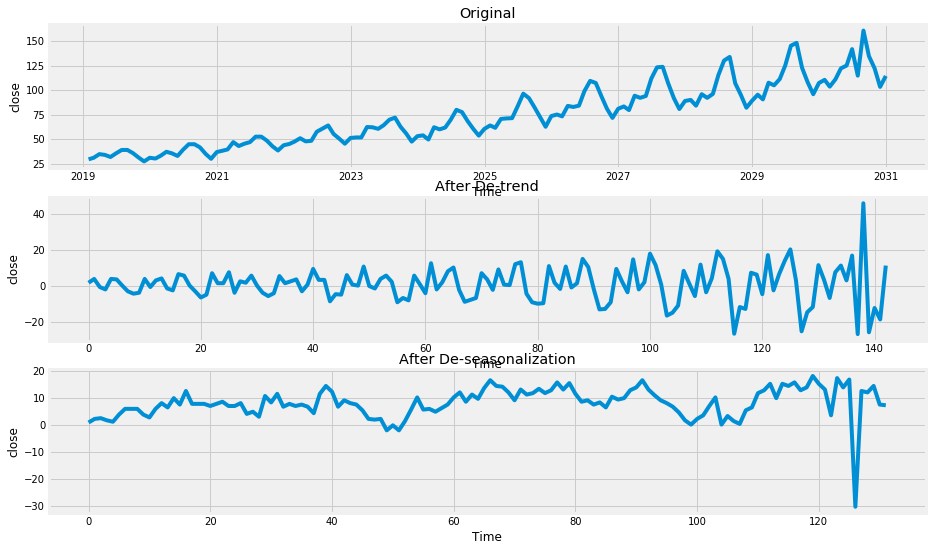

In [26]:
ts = df.groupby(["month"])["close"].agg('mean')
ts.astype('float')
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('close')

plt.plot(dateRange, ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('close')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('close')
new_ts=difference(ts,12) 
plt.plot(new_ts)
plt.plot()

With relation with the De-Trend we can see clearly that we have a increase in the oscilation in the stock price along the last part of the series. It might be caused by some market issues like interest rates by the government, more people going out from bonds and going to stock market, news, etc. The important thing here it is to understand why we had this huge increase in the volatility in the last months. 

According the Seasonal Adjustment we can detect that despite the huge drop in the final of the series, the price did oscilate between 0 and 10, that we can consider a good sign; but this sub-trend must be see very carefully because it can indicates that the time it's taking a huge factor in our stock instead of internal factors like EBITDA, operational eficiency, cost reduction, increase of the productivity and so on. 


## Modeling and Prediction

TBC

In [27]:
# Using ARIMA vanilla model
model = ARIMA(ts, order=(7, 1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(ts), len(ts), typ='levels')
print(yhat)
print(model_fit.summary())

2031-01-01    115.024455
Freq: MS, dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  143
Model:                 ARIMA(7, 1, 1)   Log Likelihood                -493.647
Method:                       css-mle   S.D. of innovations              7.531
Date:                Thu, 22 Nov 2018   AIC                           1007.295
Time:                        13:10:47   BIC                           1036.923
Sample:                    02-01-2019   HQIC                          1019.334
                         - 12-01-2030                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6814      0.057     12.022      0.000       0.570       0.792
ar.L1.D.close     0.4866      0.087      5.570      0.000       0.315   

Lets take a look in the output. The first information it's about the prediction it self. As we're using a very basic vanilla ARIMA model without anykind of optimization with one-step forward prediction. It means that our model takes in consider the past and predict the next event. In our case, our prediction for the next data point in the series it's `2031-01-01 - 115.024455`, _i.e._ the shares will value `EU 115`.

The second information it's about the `ARIMA(7, 1, 1)` these 3 parameters it's related about the mechanism that ARIMA uses to make predictions. The first one it's `p` that means the auto-regressive component of the serie, that means to measure the influence of the past in the current model. It's like to see rearview of the car to help the driving. The second parameter it's `d` that means the integration between a number of steps in the past to the actual series. And finally the last one it's the `q` that means the moving average component of the serie, where it is a combination of _n_ steps in the past smooth the data for the future. 

There's several techniques to discover the best parameters for ARIMA, since grid search and some analysis using `ACF` and `PACF` plots graphs. The main idea here it's to use a very simple model. This [blog post of Digital Ocean gives a nice overview about it](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3).

Another important piece of information it's the coeficients in the first column in the left side on the top. This column gives to us some information about the importance of the variables for the model. For now we have the information about the constant that has `const = 0.6814` and the autoregressive term with `ar.L1.D.close =  0.4866` as most significant variables and the moving average term with `ma.L1.D.close = -0.8856` the most harmful for the model. We have some measures as Standard Error `std err` and Z-Score `z` that helps us to get a real diagnosis of the model. 




# Exploratory Regression

In this case below we'll work with the data from [Residential Building dataset from UCI](https://archive.ics.uci.edu/ml/datasets/Residential+Building+Data+Set) where in the decription tells us that _"Data set includes construction cost, sale prices, project variables, and economic variables corresponding to real estate single-family residential apartments in Tehran, Iran"._

According the summary provided by UCI this dataset contains 372 records with 109 columns:
* 8 project physical and financial variables
* 19 economic variables and indices in 5 time lag numbers (5*19 = 95), and 
* two output variables that are construction costs and sale prices

This processed dataset (without headers) can be found in [Github](https://github.com/fclesio/learning-space/blob/master/Datasets/04%20-%20Linear%20Regression/residential_building_dataset_transfomed.xlsx)

The idea in this notebook it's using some regression algorithms to start the development of our production algorithm that will predict the construction costs and sale prices of a home given all the features. 

We'll perform some data analysis, feature engineering and after that we'll apply some algorithms and compare the results and elect one to start our production model.

## Imports and data load
Here we'll import some basic libraries to work with during this notebook. Ideally the best approach will be always load the library in the instant before their usage to avoid _load dead libraries_ that can make our application not so performatic because we imported unecessary and unused libraries. 

Basically we'll import some math libraries to perform some statistical analysis in the dataframe. After that we'll call some models of Scikit Learn. 

A regression with several regression coefficients (and we have more than 100!) makes the model as a whole much more complex and can take interpretability characteristics. One way to eliminate this problem, which can absorb data noise and cause overfitting, these methods retention a subset of regressors, which not only reduces the complexity of the model and the way it is calculated and constructed, as it reduces error and breaking down mimics any possibility of the model having overfitting.

These three models derived from the regression are known with Shrinkage, or Shrinkage regression methods.

These models _Elastic Net_, _Lasso_, and _Ridge_ are special in this particular problem because these libraries handle very well with datasets with high dimentionality, _i.e._ datasets with several columns. 

The whole principle behind these algorithms it's because according the column relevance to the final result (_i.e._ construction cost, sale price) they make some **penalties** in the column, reducing their weight for the final model. 

The the matter of simplicity, we can consider as a factor of penalty for each algorithm as follows:
* **Lasso**: has the same mechanism of penalization of the coefficients with a high degree of correlation among them, but that uses the mechanism to penalize the coefficients according to their absolute value (sum of the values of the estimators) using the mechanism to minimize the quadratic error. This is done by penalizing the coefficient until it converges to zero; which will naturally eliminate the attribute and reduce the dimensionality of the model.  


* **Ridge**: Is a method of regularization of the model that has as main objective to soften attributes that are related to each other and that increase the noise in the model (A.K.A multicollinearity). With the withdrawal of certain attributes of the model, it converges to a much more stable result in that with the reduction of these attributes, the reduction in the model's acuity remains unchanged. The algorithmic mechanism that does this is through a penalty mechanism that puts a bias and that will reduce the betas values to zero. Thus the attributes that contribute less to the predictive power of the model are brought to irrelevance by using this bias penalty mechanism.  


* **Elastic Net**: This method it is a mix between Lasso ans Ridge penalties.

And finally we'll import some plot libraries to see the graphs.

In [1]:
from math import sqrt
from scipy import stats
from scipy.stats import norm

from sklearn import metrics
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load spreadsheet
xl = pd.ExcelFile('residential_building_dataset_transfomed.xlsx')

# Load a sheet into a DataFrame by name: Data
df = xl.parse('Data')

# Check Shape of DataFrame
print("The dataset contains {} records with {} columns.".format(df.shape[0], df.shape[1]))

The dataset contains 372 records with 109 columns.


## Data Analysis and Feature Engineering

First at all let's take a look in our dataset and see the columns to see if we need to do some feature engineering of delete bad data of our dataset.

In [2]:
df.head(3)

,start_year,start_quarter,completion_year,completion_quarter,physical_financial_v1,physical_financial_v2,physical_financial_v3,physical_financial_v4,physical_financial_v5,physical_financial_v6,...,economic_indexes__lag5_v12,economic_indexes__lag5_v13,economic_indexes__lag5_v14,economic_indexes__lag5_v15,economic_indexes__lag5_v16,economic_indexes__lag5_v17,economic_indexes__lag5_v18,economic_indexes__lag5_v19,out_v1,out_v2
0,81,1,85,1,1,3150.0,920.0,598.5,190,1010.84,...,815.5,1755.00,8002.0,60.74,54.26,2978.26,41407.0,601988.1,2200,410
1,84,1,89,4,1,7600.0,1140.0,3040.0,400,963.81,...,1316.3,8364.78,8393.0,90.95,89.79,11379.37,44835.0,929027.1,5000,1000
2,78,1,81,4,1,4800.0,840.0,480.0,100,689.84,...,765.8,1755.00,4930.0,38.70,32.04,1653.06,37933.0,377828.6,1200,170


After a quick look we can see some things:
* Our dependent variables out_v1 and out_v1 (construction cost and sale price) have several diferences of scale. Maybe we need to check to see if this variables follow some normal distribution. Without checking it, we can break our algorithms in the trainning moment.  

* We have most of the time numerical variables, so we won't need (in this first moment) to concern about One Hot Encoding or Label Encoding. It means: less steps of pre-processing.  

* We do not have some ordinal features that needs to be transformed in this moment. 


Said that, let's take a look in our distribution of the dependent variables. 

We'll use two functions, one called `get_distribution` to get the distribution given a variable and `get_adjust_variable_to_log` to ajust the variable to `log(1+x)` scale to _normalize_ our variable and put inside of a normal distribution to enhance the algorithm learning. 

In [3]:
def get_distribution(df_column):
    import warnings
    warnings.filterwarnings("ignore")
    
    #Check the new distribution 
    sns.distplot(df_column, fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df_column)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Variable Distribution after Log(1+x) adjustment')

    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(df_column, plot=plt)
    plt.show()

Lets check the distribution for the `construction cost` variable.


 mu = 1387.43 and sigma = 1204.46



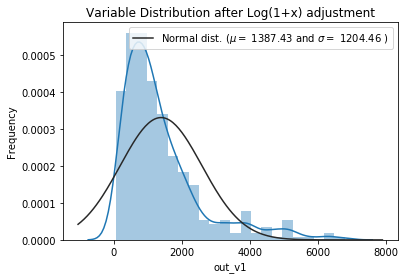

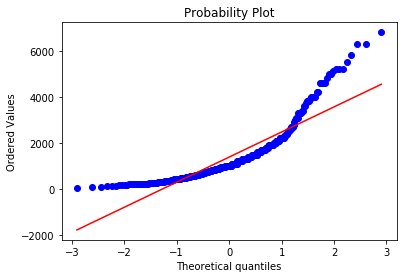

In [4]:
get_distribution(df.out_v1)

In the first graph we can see that our data do not follow a normal distribution. It can be caused by several outliers that relies in our dataset. It is crystal clear when we see the average with `mu = 1387.43` and the standard deviation with `sigma = 1204.46`.

The probability plot using QQ-plot we can check that the distribution aren't linearly related and not distributed as a standard normal (X ~ N(0,1)).

It means: We need to redefine this variable. 

Let's check the variable `sale price`


 mu = 232.65 and sigma = 162.41



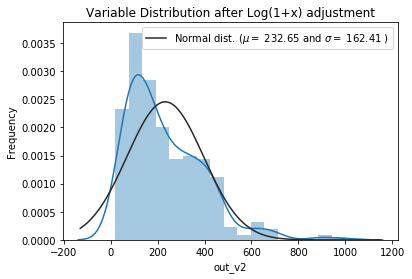

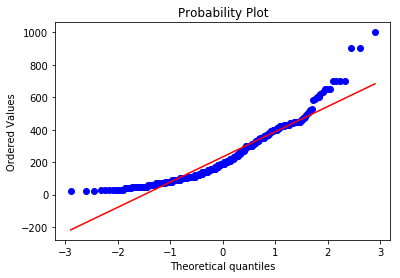

In [5]:
get_distribution(df.out_v2)

In the `sale price` we can see the same problem as the `construction cost` variable, _i.e._ the `sale price` variable do not follow a normal distribution. It becomes more clear when we see the average with mu = 232.65 and the standard deviation with sigma = 162.41.

The QQ-plot again shows that the `sale price` is not distributed as a standard normal.

Right now we'll build a function to solve that applying the `log(1+x)` transformation to the variable, and we can check the distribution again.

In [6]:
def get_adjust_variable_to_log(df_column):
    import warnings
    warnings.filterwarnings("ignore")
    
    #We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
    df_column = np.log1p(df_column)

    #Check the new distribution 
    sns.distplot(df_column, fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df_column)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Variable Distribution after Log(1+x) adjustment')

    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(df_column, plot=plt)
    plt.show()

    return df_column


 mu = 6.90 and sigma = 0.84



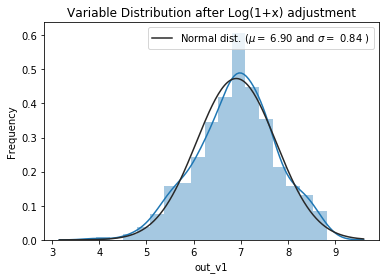

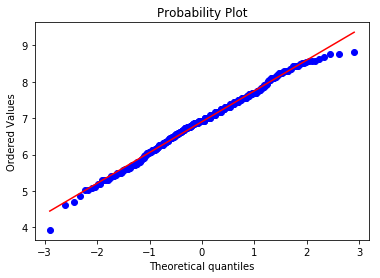


 mu = 5.20 and sigma = 0.76



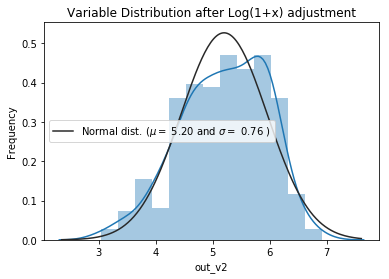

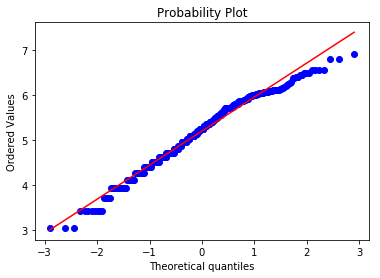

In [7]:
df.out_v1 = get_adjust_variable_to_log(df.out_v1)
df.out_v2 = get_adjust_variable_to_log(df.out_v2)

So much better. Right now we have a better distributed variable in both dependent variables with quantiles more lineary separable and with normal distributions.

In the next section we will check if we have some missing values in our dataset.

In [8]:
all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio


Great we do not have any missing value, it means that we need, for this first moment, less feature engineering to do with our data.

Said that, we'll get the values of our dataframe and put inside in some variables to split in train and test sets.

In [9]:
# Set X, Y
X = df.values[:, 0:106]
Y_1 = df["out_v1"].values
Y_2 = df["out_v2"].values

With our `X` as a set of independent variables and `Y_1` and `Y_2` as dependent variables, we;ll build a function to split our dataset in traning and test sets with 80% of all data for training and 20% for testing the accuracy of our algorithm.  

In [10]:
def get_train_and_test_sets(X, Y):
    from sklearn import model_selection
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=0)
    print("Train dataset contains {} records, {} columns.".format(X_train.shape[0], X_train.shape[1]))
    print("Test dataset contains {} records, {} columns.".format(X_test.shape[0], X_test.shape[1]))
    return X_train, X_test, Y_train, Y_test

In [11]:
X_train, X_test, Y_train, Y_test = get_train_and_test_sets(X, Y_1)

Train dataset contains 297 records, 106 columns.
Test dataset contains 75 records, 106 columns.


## Training and Test

After the preparation of our data using some quick analysis, re-scaling and divide the `train sets` and `test sets` let's do the training and the assessment of our algorithms. 

For the matter of simplicity for the baselines we'll keep the default values of all parameters. We'll do that because the whole point of this part it's to validate some initial hypotesis like:

* **Hypothesis** 1: Single shrinkage algorithms has similar performance?  


* **Hypothesis** 2: Using shrinkage algorithms as a baseline we can have better results than XGBoost?  


* **Hypothesis** 3: What it's better XGBoost with some default values or with some different parameters using Grid Search?  


* **Hypothesis** 4: In this example, XGBoost with Grid Search can beat Stacking models?  


But first let's use the following function to create our baseline models. 

### Baseline Model

We use the baseline models only to validate if it's better to keep simple with a single algorithm or using different algorithms we can have beter results.

In [12]:
def get_baseline_results(X_train, X_test, Y_train, Y_test, estimator, estimator_name):
    est = estimator
    est.fit(X_train, Y_train)
    predicted_est = est.predict(X_train)
    predictions_est = est.predict(X_test)
    print ("MSE Test - {} = {}".format(estimator_name, str(mean_squared_error(predictions_est, Y_test))))
    return predictions_est

### XGBoost with Grid Results

XGBoost according the [documentation](https://xgboost.readthedocs.io/en/latest/) it is _XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way_.

The principle behind the XGBoost it it's extends the concept of the Gradient Boosting Machine where several weak classifiers/regressors are ensembled (put together for each step) with the advantage to permit some optimizations using loss functions for each step, _i.e_ we can put a cost function to make the model converge. [This presentation made by one of the core developers of the tool gives a great overview about the principles behind XGBoost](https://www.slideshare.net/ShangxuanZhang/kaggle-winning-solution-xgboost-algorithm-let-us-learn-from-its-author).

All of that without the problems of speed processing and this algo it's able to do classification and regression tasks. 

This [link](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) it's a good reference for that, and explains the algorithm principles behind XGBoost.

For this implementation we'll use 2^4 combinations (16) of models and pick the best one and do the predictions. 

In [13]:
def get_xgboost_grid_results(X_train, Y_train, X_test, Y_test):
    from sklearn.model_selection import GridSearchCV
    
    params = {"learning_rate": [0.1, 0.01],
          'n_estimators': [300, 500],
          'max_depth': [10, 50],
          'max_leaf_nodes': [5,10]
         }

    # Initialize XGB and GridSearch
    xgb = XGBRegressor(nthread=-1, silent=1)
    grid = GridSearchCV(xgb, params)
    grid.fit(X_train, Y_train)
    print ("MSE Test (Grid Search) = {}".format(str(mean_squared_error(grid.best_estimator_.predict(X_test), Y_test))))

### Stacking Regressors

Let's think: Every regressor have their vantages, disvantages, features and so on. Starting from this principle, what if we can mix multiple models and send the result of their predictions to a final algorithm?

This is the concept behind Stacking. Basically we can use several models and get these outputs and use a final regressor (called meta learner, because it will learn on the top of others).

The following image describe how this process works. 

<img src="stacking.jpeg">

Ref:: [Quora](https://www.quora.com/What-is-stacking-in-machine-learning)

So in our Stacking model we'll adopt a strategy to use the `linear model` as a meta learner and get the results of other algorithms combined. 

In [14]:
def get_stacking_results(X_train, Y_train, X_test, Y_test):
    from mlxtend.regressor import StackingRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import LinearRegression
    from sklearn.neural_network import MLPRegressor
    
    import warnings
    warnings.filterwarnings("ignore")

    # Initialize models
    lr = LinearRegression(n_jobs = -1)
    rd = Ridge()
    la = Lasso()
    en = ElasticNet()
    rf = RandomForestRegressor(n_jobs = -1)
    gb = GradientBoostingRegressor()
    nn = MLPRegressor(hidden_layer_sizes = (90, 90, 90 , 90),alpha = 2.75)
    xb = XGBRegressor(nthread=-1, silent=1)

    # Initialize Ensemble
    stk = StackingRegressor(regressors=[rd, rf, gb, nn, xb, la, en], meta_regressor=lr)

    # Fit the model on our data
    stk.fit(X_train, Y_train)

    # Predict training and test set
    predicted_stk = stk.predict(X_train)
    predictions_stk = stk.predict(X_test)

    #print ("MSE Train (Staking) = {}".format(str(metrics.mean_squared_error(Y_train, predicted_stk))))
    print ("MSE Test (Staking) = {}".format(str(mean_squared_error(predictions_stk, Y_test))))

## Results and Discussion

First at all lets get the results of our baseline models. 

### Baseline Results

In [15]:
lasso_baseline = get_baseline_results(X_train, X_test, Y_train, Y_test, Lasso(), 'Lasso')
ridge_baseline = get_baseline_results(X_train, X_test, Y_train, Y_test, Ridge(), 'Ridge')
elastic_net_baseline = get_baseline_results(X_train, X_test, Y_train, Y_test, ElasticNet(), 'ElasticNet')
xgboost_baseline = get_baseline_results(X_train, X_test, Y_train, Y_test, XGBRegressor(), 'XGBoost')

MSE Test - Lasso = 0.0820962257998939
MSE Test - Ridge = 0.07838183467197497
MSE Test - ElasticNet = 0.0822691219481925
MSE Test - XGBoost = 0.0071108498694162


### XGboost Results

In [16]:
get_xgboost_grid_results(X_train, Y_train, X_test, Y_test)

MSE Test (Grid Search) = 0.006642905623788485


### Stacking Results

In [17]:
get_stacking_results(X_train, Y_train, X_test, Y_test)

MSE Test (Staking) = 0.008218919542734201


### Discussion

Based in the MSE of our models, we can validate our hypothesis. Let's check it out:

* **Hypothesis** 1: Single shrinkage algorithms has similar performance?  
* **Result**: Yes. they have similar performances with a slightly advantage for the Ridge regression. It doesn't mean that this method it's better or not, but according with this data this method in particular showed a better result. 



* **Hypothesis** 2: Using shrinkage algorithms as a baseline we can have better results than XGBoost?  
* **Result**: No. As we can see the best result was for `Ridge = 0.0783818` but the baseline model using XGBoost gave `XGBoost = 0.00711084`. Almost 10x better without a single optimization. It shows that XGboost it's a great technique for Regression Problems.



* **Hypothesis** 3: What it's better XGBoost with some default values or with some different parameters using Grid Search?  
* **Result**: XGBoost with Grid Search. With Grid Search we had `(Grid Search) = 0.006642905` against `XGBoost = 0.00711084` of the baseline. It is almost 10% of advantage with only 16 combinations. If we expand this for more combinations maybe we can have better results. 



* **Hypothesis** 4: In this example, XGBoost with Grid Search can beat Stacking models?  
* **Result**: Yes, XGBoost with Grid Search in this example beat Stacking Models. With Grid Search we had `(Grid Search) = 0.006642905` against `(Staking) = 0.0080646186` of the Staking. But the Stacking model showed a great result using only some default params and without any kind of optimization, so more tests are needed to ensure with is the best. 